In [1]:
import pandas as pd
import numpy as np
import math
import random
import scipy
import statistics
import statsmodels.formula.api as smf
import sklearn.linear_model as lm

import keras

import matplotlib.pyplot as plt
%matplotlib inline

/Users/dannytb/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#Global Variables 
train_test_split = .8 #fraction of data to use for training

!ls

Final Project.ipynb    HRDataset_v13.csv      winequality-red.csv
Final_Project_v2.ipynb ph_v1_days.csv


# Dataset Info:
I will ba anylizing a red wine dataset that has 11 features of wine and corresponding reviews of the wine by critics. The goal is to preict the critics score from the acidity, citric acid, sugar, etc. Becoming a professional wine taster can take years of education, so if we sucessfully create a model to accruaty rate wine from machine producible data, the cost of generating ratings would drasticly decrease. 

In [37]:
pdth = pd.read_csv("winequality-red.csv")
print(pdth.head())
print("Total Availible Keys: ", len(pdth.keys()))

repl_nan = lambda x: list(map(lambda xx: 0 if math.isnan(xx) else xx, x))

qualtities = list(map(lambda x: int(x), repl_nan(pdth['quality'])))

normalizers = {}
for k in pdth.keys():
    if k in ["quality"]:
        continue
    normalizers[k]=statistics.mean(repl_nan(list(map(lambda x: float(x), pdth[k]))))

xs = []
for k in pdth.keys():
    if k in ["quality"]:
        continue
    xs.append(repl_nan(list(map(lambda x: float(x)/normalizers[k], pdth[k]))))
    
# Put the data into numpy arrays
xs=np.transpose(np.array(xs))
ys=np.array(qualtities)

#Xshape = (num_samples, features), Yshape = (num_samples,)
print("\nPre Split Shapes:")
print("X shape = {}, Y shape = {}".format(xs.shape, ys.shape))

#Create a training and testing split

#Zip the xs and ys together
xsys = list(zip(xs, ys))

#shuffle the combined list
random.shuffle(xsys)

#Unzip the shuffled list
xsk, ysk = zip(*xsys)

splt_ndx = int(len(xsk)*train_test_split)

xs_tr = np.array(xsk[0:splt_ndx]); xs_ts = np.array(xsk[splt_ndx:])
ys_tr = np.array(ysk[0:splt_ndx]); ys_ts = np.array(ysk[splt_ndx:])

#Print the final shapes
print("\nFinal Shapes:")
print("Shapes: X train = {}, Y train = {}".format(xs_tr.shape, ys_tr.shape))
print("        X test  = {},  Y test  = {}".format(xs_ts.shape, ys_ts.shape))

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5 

# Data Analysis
Some minor data analysis to show the coorelation between some of the variables and the quality. It will be intersting to see if there is any correlation or unique combinations of properties lead to a good tasting wine. 

fixed acidity vs quality
volatile acidity vs quality
citric acid vs quality
residual sugar vs quality
chlorides vs quality
free sulfur dioxide vs quality
total sulfur dioxide vs quality
density vs quality
pH vs quality
sulphates vs quality
alcohol vs quality


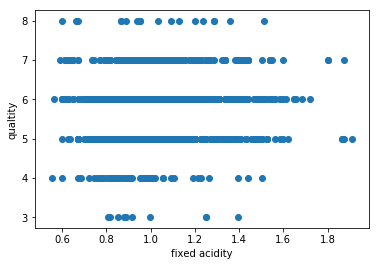

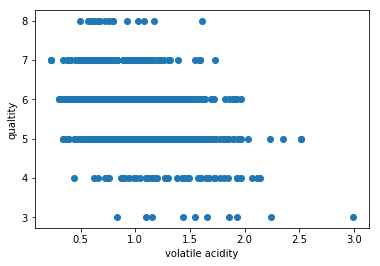

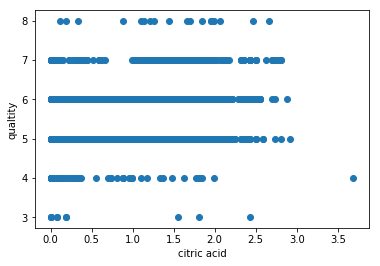

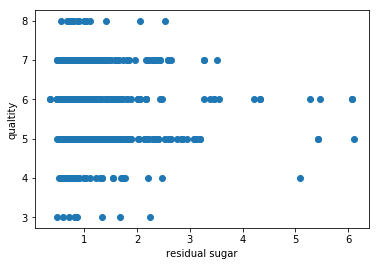

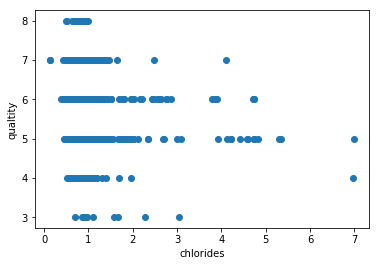

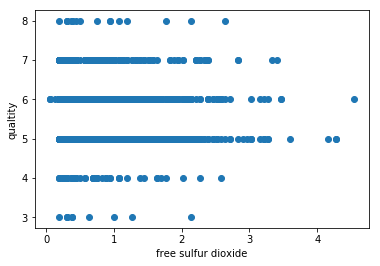

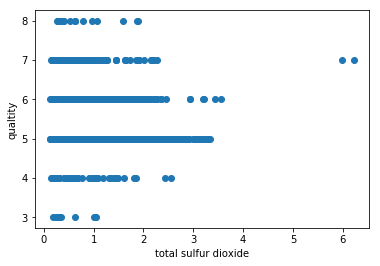

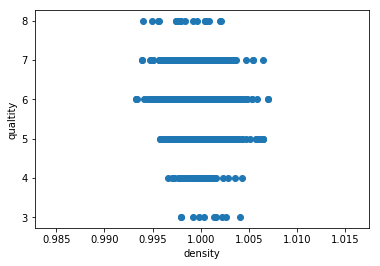

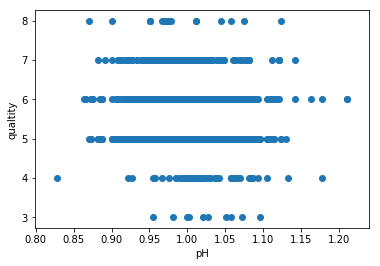

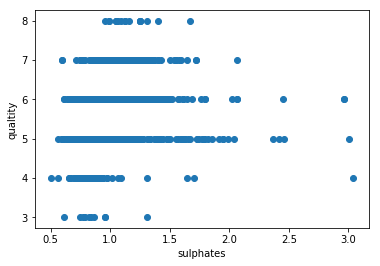

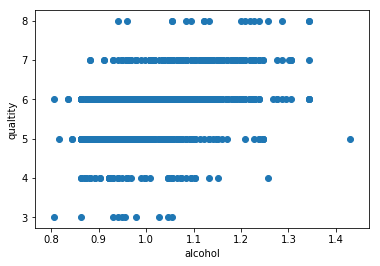

In [38]:
for ii in range(xs.shape[1]):
    plt.figure()
    print(str(pdth.keys()[ii]+" vs quality"))
    plt.scatter(xs[:, ii], ys)
    plt.xlabel(pdth.keys()[ii])
    plt.ylabel("qualtity")

It appears as if the combination of certain preoperties leads to a good tasting wine. However, there are some trends we can see. For example, looking at the volitile acidity vs quality plot, lower quality wines tend to have higher volitile acitdity. I cannot see any other apparent trends from looking at the scatterplots. However; to get a more mathematical relationship, i will examine the covariances of the variables.

In [39]:
for ii in range(xs.shape[1]):
    covvr = np.zeros((xs[:, ii].shape[0], 2))
    covvr[:, 0] = xs[:, ii]
    covvr[:, 1] = ys
    print("COR(", pdth.keys()[ii],", quality) = ", np.cov(np.transpose(covvr))[0,1])

COR( fixed acidity , quality) =  0.02096528753792779
COR( volatile acidity , quality) =  -0.10699827298089092
COR( citric acid , quality) =  0.13142102695876595
COR( residual sugar , quality) =  0.0061584259456243535
COR( chlorides , quality) =  -0.05601621876622553
COR( free sulfur dioxide , quality) =  -0.02695490877148281
COR( total sulfur dioxide , quality) =  -0.10582032889554789
COR( density , quality) =  -0.0002674738832672829
COR( pH , quality) =  -0.002173837588535153
COR( sulphates , quality) =  0.05228818492375625
COR( alcohol , quality) =  0.039315904699310684


As seen, most covariances are pretty small, however vitric acid and volitile acidity appear to play some minor role in directly effecting the quality. 

# Model Fitting
1) Fit a logistic regresion model as a baseline 

2) Fit a fully connected neural network to try to get the best score possible

In [40]:
model_lr = lm.LogisticRegression(solver='liblinear')
model_lr.fit(xs_tr, ys_tr)


def get_acc_lr(x, y, allow_diff=0):
    preds = model_lr.predict(x)
    crr=0
    for xx, yy in zip(preds, y):
        if abs(xx-yy)<=allow_diff:
            crr+=1
    
    return crr/len(y)

print("Training Accuracy = ", get_acc_lr(xs_tr, ys_tr))
print("Testing  Accuracy = ", get_acc_lr(xs_ts, ys_ts))

print("Training Accuracy (allow 1 diff) = ", get_acc_lr(xs_tr, ys_tr, allow_diff=1))
print("Testing  Accuracy (allow 1 diff) = ", get_acc_lr(xs_ts, ys_ts, allow_diff=1))


Training Accuracy =  0.5863956215793589
Testing  Accuracy =  0.575
Training Accuracy (allow 1 diff) =  0.9609069585613761
Testing  Accuracy (allow 1 diff) =  0.959375


#### Model Analysis
The model fails to have good n+1 precision. While it mostly always gets within 1 of human prediction (seen in the Accuracy (allow 1 diff) metric), the qualties are usually pretty close so n+1 precision is more important. 

Training Accuracy =  0.6684910086004691 , Training Sensitivity =  0.6684910086004691 , Training Specificity =  0.9631656676222743
Testing  Accuracy =  0.621875 , Testing Sensitivity =  0.621875 , Testing Specificity =  0.9579861111111111
Training Accuracy (allowed 1 diffrence) =  0.9788897576231431
Testing  Accuracy (allowed 1 diffrence) =  0.965625


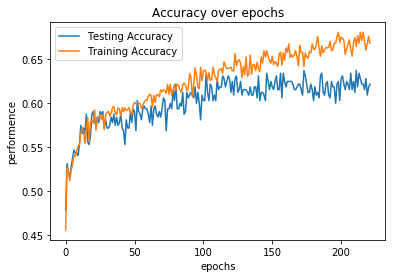

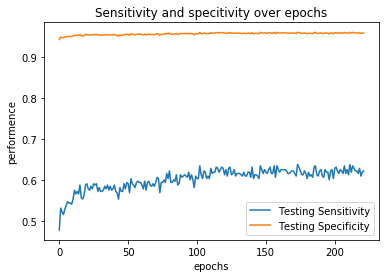

In [71]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

def get_acc_ml(x, y, allow_diff=0):
    preds = model_ml.predict(x)
    crr=0
    tps=tns=fps=fns=0
    num_classes = y.shape[1]
    for xx, yy in zip(preds, y):
        xxp = np.argmax(xx)
        yyp = np.argmax(yy)
        if abs(xxp-yyp)<=allow_diff:
            crr+=1
            
        if xxp==yyp:
            tps+=1
            tns+=num_classes-1
        else:
            fps+=1
            tns+=num_classes-2
            fns+=1

    accrc = float(crr)/len(y)
    sensc = float(tps)/(tps+fns)
    spesc = float(tns)/(fps+tns)

    return accrc, sensc, spesc

# Make one hot encodings of the ys 
ys_tr_oh = np.zeros((len(ys_tr), 10))
ys_ts_oh = np.zeros((len(ys_ts), 10))

for i, n in enumerate(ys_tr):
    ys_tr_oh[i, n-1]=1
    
for i, n in enumerate(ys_ts):
    ys_ts_oh[i, n-1]=1

hddn_units = 128
model_ml = Sequential([
    Dense(hddn_units, activation='relu'), 
    Dropout(.5),
    Dense(hddn_units, activation='relu'), 
    Dropout(.5),
    Dense(hddn_units, activation='relu'), 
    Dropout(.25),
    Dense(10, activation='softmax')
])
model_ml.compile(optimizer='adam', loss='categorical_crossentropy')

eps = 222

accs_ts = []
accs_tr = []
sens = []
spes = []
for ee in range(eps):
    model_ml.fit(xs_tr, ys_tr_oh, initial_epoch=ee, epochs=ee+1, verbose=0)
    accr, sensc, spesc = get_acc_ml(xs_ts, ys_ts_oh)
    accs_ts.append(accr)
    sens.append(sensc)
    spes.append(spesc)
    
    accs_tr.append(get_acc_ml(xs_tr, ys_tr_oh)[0])
    
plt.figure()
plt.title("Accuracy over epochs")
plt.xlabel("epochs")
plt.ylabel("performence")
plt.plot(accs_ts)
plt.plot(accs_tr)
plt.legend(["Testing Accuracy", "Training Accuracy"])

plt.figure()
plt.title("Sensitivity and specitivity over epochs")
plt.xlabel("epochs")
plt.ylabel("performence")
plt.plot(sens)
plt.plot(spes)
plt.legend(["Testing Sensitivity", "Testing Specificity"])

tr_acc, tr_sens, tr_spes = get_acc_ml(xs_tr, ys_tr_oh)
ts_acc, ts_sens, ts_spes = get_acc_ml(xs_ts, ys_ts_oh)
print("Training Accuracy = ", tr_acc, ", Training Sensitivity = ", tr_sens, ", Training Specificity = ", tr_spes)
print("Testing  Accuracy = ", ts_acc, ", Testing Sensitivity = ", ts_sens, ", Testing Specificity = ", ts_spes)

print("Training Accuracy (allowed 1 diffrence) = ", get_acc_ml(xs_tr, ys_tr_oh, allow_diff=1)[0])
print("Testing  Accuracy (allowed 1 diffrence) = ", get_acc_ml(xs_ts, ys_ts_oh, allow_diff=1)[0])

### Model analysis
The fully connected network was able to increase testing accuracy from the baseline by more than 15%. 

1) while overfitting still occured, it was reduced by addin dropout between layers. The dropout was 50%, 50% adn 25% over the layers, meaning 50% of the neurons were zeroed in the first layer during training, 50% in the second and 25% in the third. No weights were zeroed in the last layer. 

2) Performence was measured using 3 metrics. Accuracy, Sensitivity and Specificity . 
    These were recorded at each epoch and plotted at the end of training. 

## Making the greatest wine
Out of curiosity, I used the model I created above to determine which combination of features would produce the greatest wine. Due to manufacturing constraints, I assume that the min/max value in each of the feature tables is what is manufacturable then loop through possibilities. 